# Tooling to compare and assess annotations from different sources



In [135]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Paper to be assessed
pmid = "3073535"

# Other parameters
gpt_version = "7"

# Get GPT outputs
gpt_files = [f for f in os.listdir("../gpt_ann/version" + gpt_version) if f.endswith(".ann")]
# filter for file names starting with pmid
gpt_files = [f for f in gpt_files if f.startswith(pmid)]

# get table from each of the files -> list of data.frames
gpt_tables = []
for gpt_file in gpt_files:
    with open(f"../gpt_ann/version{gpt_version}/{gpt_file}", "r") as f:
        # read tab-delimited file
        table = pd.read_csv(f, sep="\t", header=None)
        # add column names (if 6 columns)
        if table.shape[1] == 6:
            table.columns = ["ID", "Type", "Start", "End", "Text", "Quality"]
        elif table.shape[1] == 7: 
            table.columns = ["ID", "Type", "Start", "End", "Text", "Quality", "Extract"]

        # add column with file name + "gpt" + version
        table["File"] = gpt_file
        table["Source"] = "gpt_v" + gpt_version
        gpt_tables.append(table)


# Join all tables
gpt_table = pd.concat(gpt_tables)

# Filter for rows with Text != nan
gpt_table = gpt_table[gpt_table["Text"].notna()]

In [157]:
# Extract comparison for each entity type
comparison  = []
for entity_type in gpt_table["Type"].unique():
    # Get entities from GPT
    entities = gpt_table[gpt_table["Type"] == entity_type]
    # Compare coordinates
    comparison.append({
        "Entity": entity_type,
        # Count of entities per file
        "Count": entities["File"].value_counts().to_dict()
    })
# Count per Text
comparison2 = []

for entity_term in gpt_table["Text"].unique():
    # Get entities from GPT
    entities = gpt_table[gpt_table["Text"] == entity_term]
    # Compare coordinates
    # for loop over different entity types
    for entity_type in entities["Type"].unique():
       entities2 = entities[entities["Type"] == entity_type]
       comparison2.append({
           "Text": entity_type + ": " + entity_term,
           # Count of entities per file
           "Count": entities2["File"].value_counts().to_dict()
    })





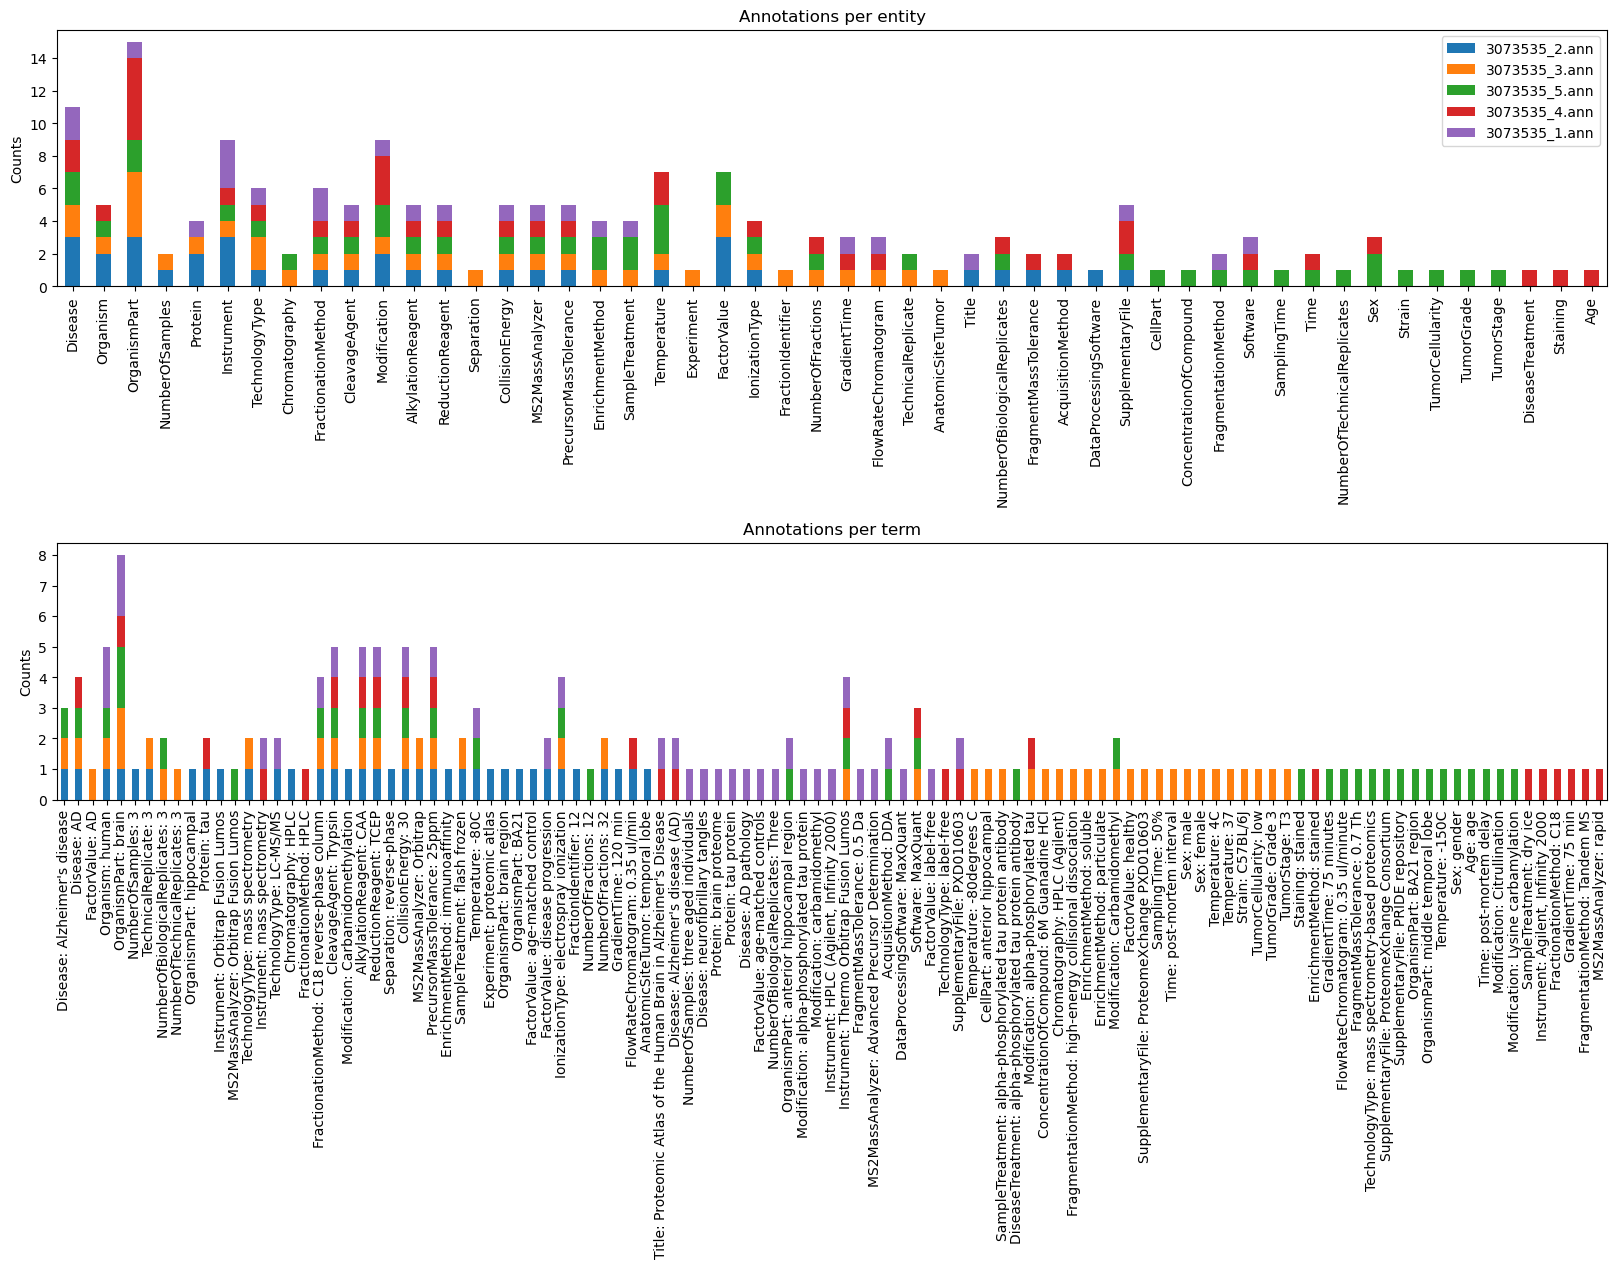

In [158]:
# Visualize comparisons
# visualize counts in one bar plot

# Create figure with enough space for x labels
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
# add space between subplots
plt.subplots_adjust(hspace=1)

# Create data frame
comparison_df = pd.DataFrame(comparison)
comparison2_df = pd.DataFrame(comparison2)
# Count of files per entities
count_df = pd.DataFrame(comparison_df["Count"].tolist()).fillna(0)
text_count_df = pd.DataFrame(comparison2_df["Count"].tolist()).fillna(0)
# Remove labels from "Count"
text_count_df.columns = [f"Files_{col}" for col in text_count_df.columns]

# Plot counts
count_df.plot(kind="bar", stacked=True, ax=ax[0])
# set entities as x labels
ax[0].set_xticklabels(comparison_df["Entity"])
ax[0].set_title("Annotations per entity")
ax[0].set_ylabel("Counts")

# plot values
text_count_df.plot(kind="bar", stacked=True, ax=ax[1])
# set entities as x labels
ax[1].set_xticklabels(comparison2_df["Text"])
ax[1].set_title("Annotations per term")
ax[1].set_ylabel("Counts")
# no legend
ax[1].legend().set_visible(False)

In [152]:
# Create named vector with values
comparison2_df["Text"]

0                      [Disease: Alzheimer's disease_0]
1                    [Disease: AD_1, FactorValue: AD_1]
2                                   [Organism: human_2]
3                               [OrganismPart: brain_3]
4     [NumberOfSamples: 3_4, TechnicalReplicate: 3_4...
                            ...                        
92              [Instrument: Agilent, Infinity 2000_92]
93                        [FractionationMethod: C18_93]
94                            [GradientTime: 75 min_94]
95                  [FragmentationMethod: Tandem MS_95]
96                          [MS2MassAnalyzer: rapid_96]
Name: Text, Length: 97, dtype: object